In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy.io
import glob,csv

from pykrige.ok import OrdinaryKriging
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [2]:
data=scipy.io.loadmat('ANHA4_Pa_diss.mat')
NEMO_dep=data['NEMO_dep']
Pa_diss=data['Pa_diss']
#print Pa_diss.shape
lons=data['lons']
lats=data['lats']
Pa_ini=np.empty([1,50,800,544])

coordinate_name=glob.glob('/ocean/xiaoxiny/research/data/Jasper/ANHA4_IC_T.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]
ANHAdep=coordinate_obj.variables['deptht'][:]
#print ANHAdep
print ANHAdep[43]

3220.82


In [3]:
'input boundinglat'
latlim=45

In [4]:
what=np.empty([len(ANHAdep),len(Pa_diss[0,:]),len(Pa_diss[0,:])])
            #layer,distance,variance
whatt=np.empty([len(ANHAdep),len(Pa_diss[0,:]),len(Pa_diss[0,:])])
x_all=[]#np.empty([len(ANHAdep),len(Pa_diss[0,:])])
            #layer,x,y
y_all=[]#np.empty([len(ANHAdep),len(Pa_diss[0,:])])
z_all=[]#np.empty([len(ANHAdep),len(Pa_diss[0,:])])
def find(layer):
        x=lons[layer,:]
        y=lats[layer,:]
        z=Pa_diss[layer,:]
        
        x_ma=np.ma.masked_where(z<= 1e-200,x)
        x_ma=np.ma.masked_where(np.isnan(x_ma),x_ma)
        y_ma=np.ma.masked_where(z<= 1e-200,y)
        y_ma=np.ma.masked_where(np.isnan(y_ma),y_ma)
        z_ma=np.ma.masked_where(z<= 1e-200,z)
        z_ma=np.ma.masked_where(np.isnan(y_ma),z_ma)        
        #x_ma=x_ma.compressed()
        #y_ma=y_ma.compressed()
        #z_ma=z_ma.compressed()
        
        
        m = Basemap(projection='npstere',boundinglat=latlim,lon_0=0,resolution='l')
        x_dis,y_dis = m(x_ma, y_ma)
        x_lon,y_lat = m(nav_lon, nav_lat)
        a,b=m(0,90)
        
        xx_lon=np.empty([800,544])
        yy_lat=np.empty([800,544])
        xx_dis=np.empty([len(x_dis)])
        yy_dis=np.empty([len(x_dis)])

        for j in range (544):
            for i in range (800):
                xx_lon[i,j]=x_lon[i,j]-a
                yy_lat[i,j]=y_lat[i,j]-b
        
        xx_lon_ma=np.ma.masked_where(nav_lat<45,xx_lon)
        yy_lat_ma=np.ma.masked_where(nav_lat<45,yy_lat)

        xx_dis=np.ma.masked_where(np.isnan(xx_dis),xx_dis)
        yy_dis=np.ma.masked_where(np.isnan(yy_dis),yy_dis)
        z_ma=np.ma.masked_where(np.isnan(yy_dis),z_ma)
        
        for k in range (len(xx_dis)):
            xx_dis[k]=x_dis[k]-a
            yy_dis[k]=y_dis[k]-b        

        xxx_dis=xx_dis.compressed()
        yyy_dis=yy_dis.compressed()
        zzz_ma=z_ma.compressed()
        
#        woww=[np.empty([len(xxx_dis),len(xxx_dis)])]
#        wow=np.empty([len(xxx_dis),len(xxx_dis)])
#        c=np.average(zzz_ma)
#        for k in range (len(xxx_dis)):
#            for j in range (len(xxx_dis)):
#                woww[k,j]=((xxx_dis[k]-xxx_dis[j])**2+(yyy_dis[k]-yyy_dis[j])**2)**0.5
#                wow[k,j]=0.5*c*(zzz_ma[k]-zzz_ma[j])**2
                
#        what[layer,:,:]=wow[:,:]
#        whatt[layer,:,:]=woww[:,:]
        for applen in range(len(xxx_dis)):
            x_all.append(xxx_dis[applen])
            y_all.append(yyy_dis[applen])
            z_all.append(zzz_ma[applen])
        #print z_all

In [5]:
for i in range (43):#no data below layer 43
    find(i)

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'linear' Variogram Model
Slope: 2.76467007163e-09
Nugget: 0.00311331749382 



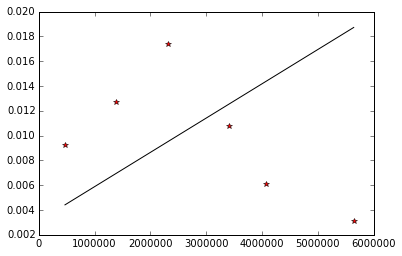

/home/xiaoxiny/anaconda/lib/python2.7/site-packages/pykrige/core.py:239: RuntimeWarning: invalid value encountered in sqrt
  sigma[n] = np.sqrt(ss_)
/home/xiaoxiny/anaconda/lib/python2.7/site-packages/pykrige/core.py:243: RuntimeWarning: divide by zero encountered in divide
  epsilon = delta/sigma


Calculating statistics on variogram model fit...
Q1 = nan
Q2 = nan
cR = nan 

Updating variogram mode...
Using 'linear' Variogram Model
Slope: 3.18558666753e-09
Nugget: 0.002004064824 



/home/xiaoxiny/anaconda/lib/python2.7/site-packages/pykrige/core.py:243: RuntimeWarning: invalid value encountered in divide
  epsilon = delta/sigma
/home/xiaoxiny/anaconda/lib/python2.7/site-packages/pykrige/core.py:257: RuntimeWarning: divide by zero encountered in log
  return Q2 * np.exp(np.sum(np.log(sigma**2))/sigma.shape[0])


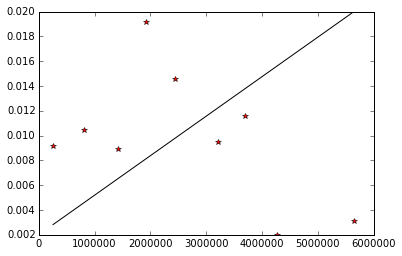

Calculating statistics on variogram model fit...
Q1 = nan
Q2 = nan
cR = nan 



In [6]:
OK = OrdinaryKriging(x_all,y_all, z_all, variogram_model='linear', verbose=True, enable_plotting=True)
OK.update_variogram_model('linear',variogram_parameters=None,nlags=10,anisotropy_angle=0)

In [7]:
'''Input slope and intercept'''
slope=3.18558666753e-09
inter=0.002004064824
lim=45

In [9]:
#write a function of  interpolation

def write_nc(layer):
        x=lons[layer,:]
        y=lats[layer,:]
        z=Pa_diss[layer,:]
        x_ma=np.ma.masked_where(z<= 1e-200,x)
        x_ma=np.ma.masked_where(np.isnan(x_ma),x_ma)
        y_ma=np.ma.masked_where(z<= 1e-200,y)
        y_ma=np.ma.masked_where(np.isnan(y_ma),y_ma)
        z_ma=np.ma.masked_where(z<= 1e-200,z)
        z_ma=np.ma.masked_where(np.isnan(y_ma),z_ma)        
        x_ma=x_ma.compressed()
        y_ma=y_ma.compressed()
        z_ma=z_ma.compressed()
        
        m = Basemap(projection='npstere',boundinglat=latlim,lon_0=0,resolution='l')
        x_dis,y_dis = m(x_ma, y_ma)
        x_lon,y_lat = m(nav_lon, nav_lat)
        a,b=m(0,90)
        
        xx_lon=np.empty([800,544])
        yy_lat=np.empty([800,544])
        xx_dis=np.empty([len(x_dis)])
        yy_dis=np.empty([len(x_dis)])

        for j in range (544):
            for i in range (800):
                xx_lon[i,j]=x_lon[i,j]-a
                yy_lat[i,j]=y_lat[i,j]-b
        
        xx_lon_ma=np.ma.masked_where(nav_lat<45,xx_lon)
        yy_lat_ma=np.ma.masked_where(nav_lat<45,yy_lat)

        xx_dis=np.ma.masked_where(np.isnan(xx_dis),xx_dis)
        yy_dis=np.ma.masked_where(np.isnan(yy_dis),yy_dis)
        z_ma=np.ma.masked_where(np.isnan(yy_dis),z_ma)
        
        for k in range (len(xx_dis)):
            xx_dis[k]=x_dis[k]-a
            yy_dis[k]=y_dis[k]-b        

        xxx_dis=xx_dis.compressed()
        yyy_dis=yy_dis.compressed()
        zzz_ma=z_ma.compressed()
        #print ('zzz_ma %s'%zzz_ma)
        #print ('xxx_dis %s'%xxx_dis)
        #print ('yyy_dis %s'%yyy_dis)
        
        OK = OrdinaryKriging(xxx_dis,yyy_dis, zzz_ma, variogram_model='linear', verbose=False, enable_plotting=False)
        OK.update_variogram_model('linear',variogram_parameters=[slope,inter],nlags=7,anisotropy_angle=0)
        
        Pa_interp, ss = OK.execute('points',xx_lon, yy_lat)
        Pa_interp=Pa_interp.reshape(800,544)
        #print Pa_interp
        
        fig=plt.figure(figsize=(8, 8)); ax=plt.gca()
        m = Basemap(projection='npstere',boundinglat=latlim,lon_0=0,resolution='l')
        m.drawcoastlines()
        m.fillcontinents(color = '0.9',alpha=0.2)
        m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
        x,y = m(nav_lon, nav_lat)
        #plt.plot(x[300:-1,:],y[300:-1,:],x[300:-1,:].T,y[300:-1,:].T,color='k',linewidth=0.1,)
        CS = m.pcolor(x[300:-1,:],y[300:-1,:],Pa_interp[300:-1,:],cmap=plt.cm.YlOrBr)
        CBar = plt.colorbar(CS, shrink=0.8)
        #m.scatter(x[0,90],y[0,90],color='yellow',s=100)
        x_mma=x_ma#.compressed()
        y_mma=y_ma#.compressed()
        for j in range(len(x_mma)):
            x2,y2= m(x_mma[j], y_mma[j])
            cmm = plt.cm.get_cmap('YlOrBr')
            m.scatter(x2,y2,c=zzz_ma[j],vmin=np.min(Pa_interp[300:-1,:]),vmax=np.max(Pa_interp[300:-1,:]),cmap=cmm,s=80)
        #fig.savefig('fig%s.pdf'%layer)
        plt.title('Layer %s'%layer)
        
        Pa_ini[-1,layer,:,:]=Pa_interp
        if layer==43:
            Pa_ini[-1,43:-1,:,:]=Pa_interp
        plt.show()

#diss Pa interpolation_result

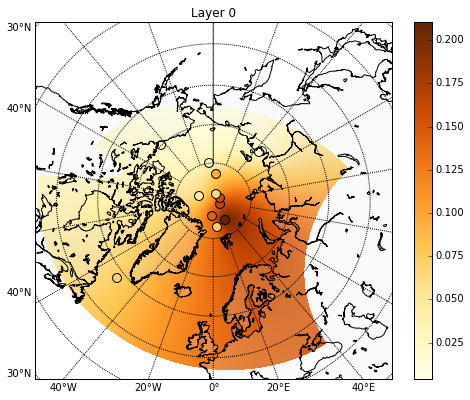

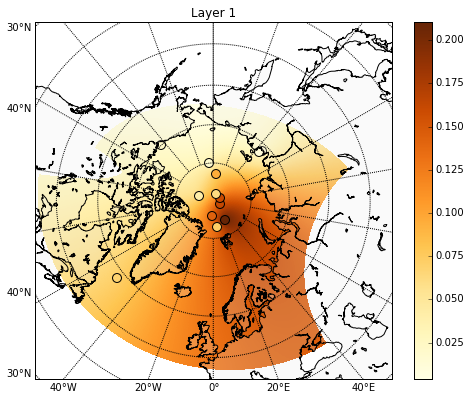

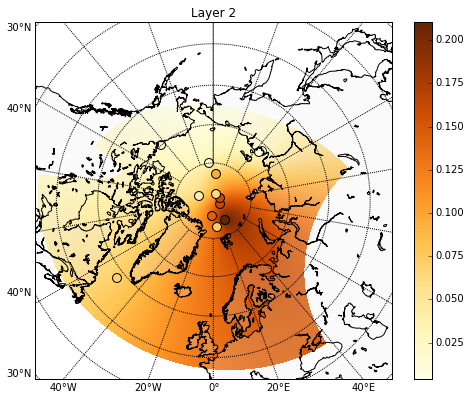

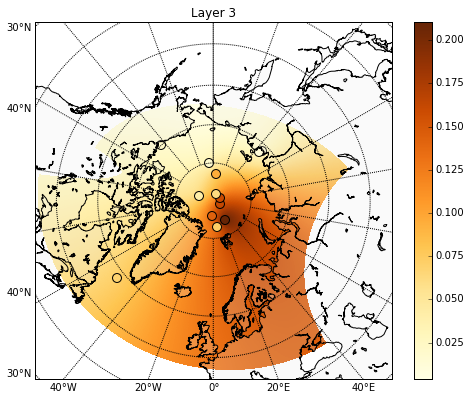

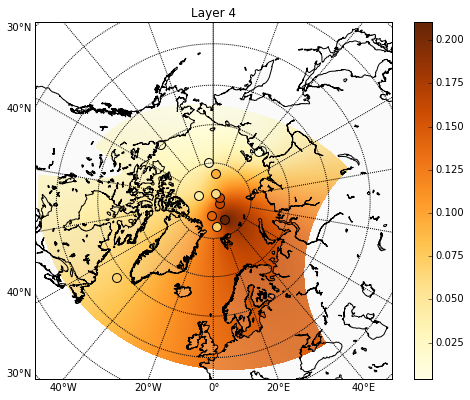

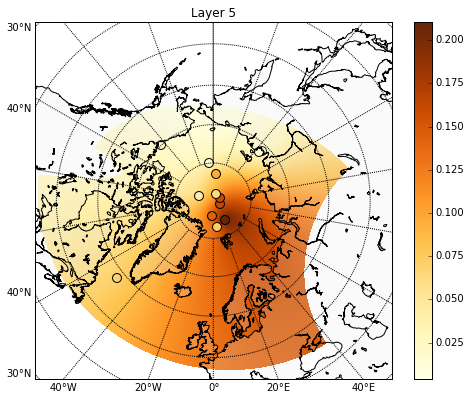

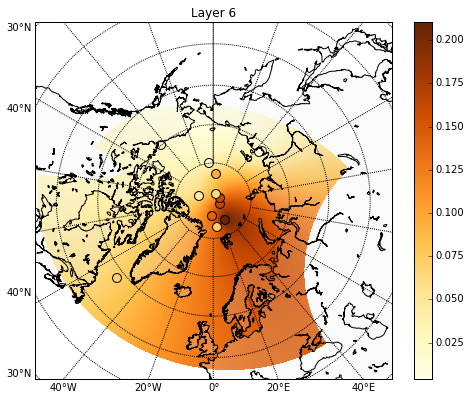

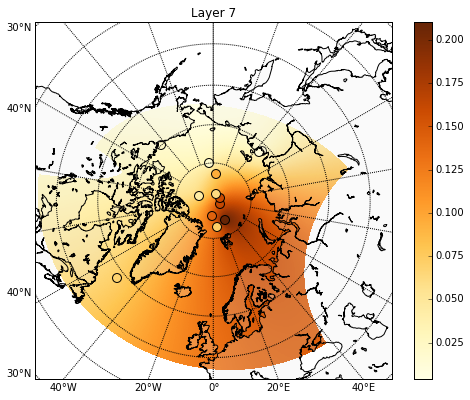

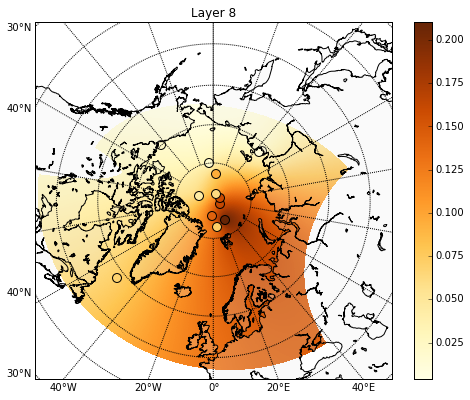

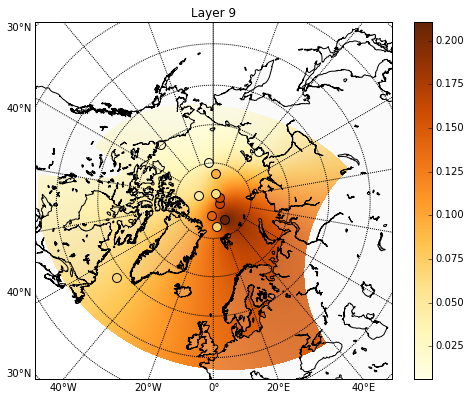

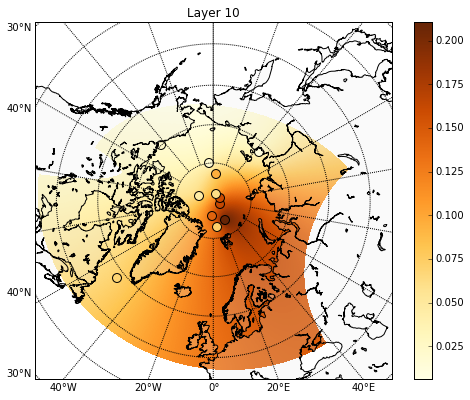

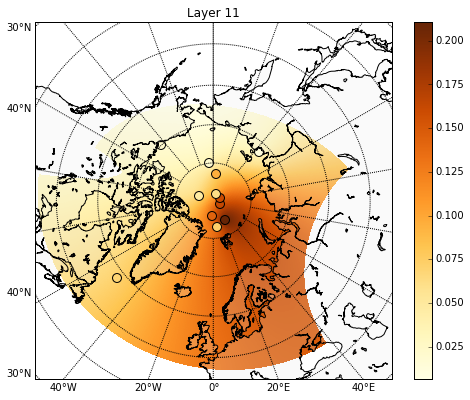

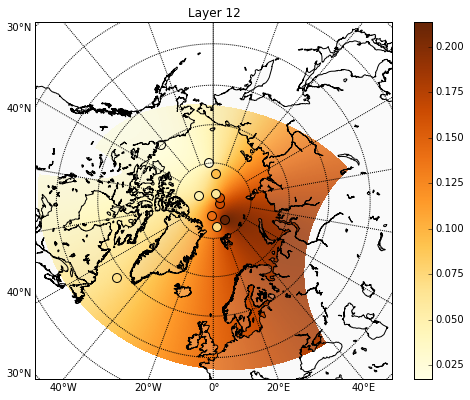

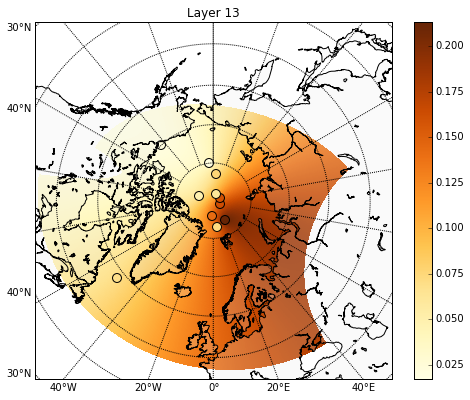

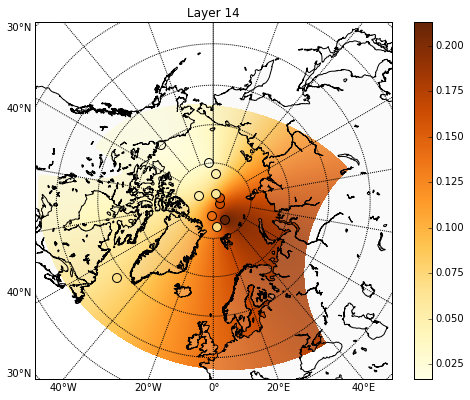

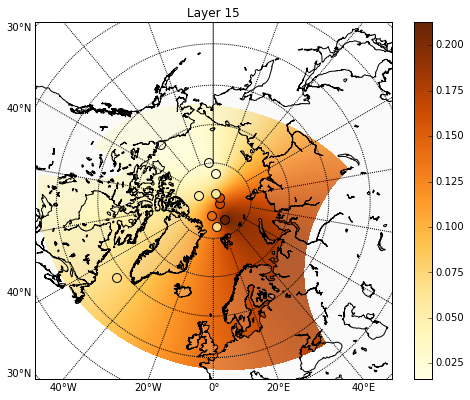

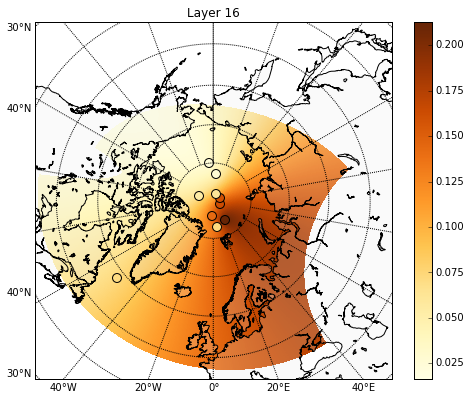

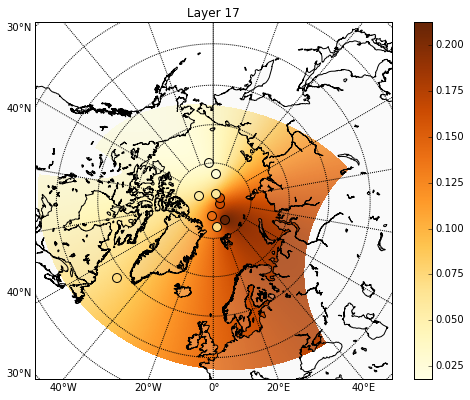

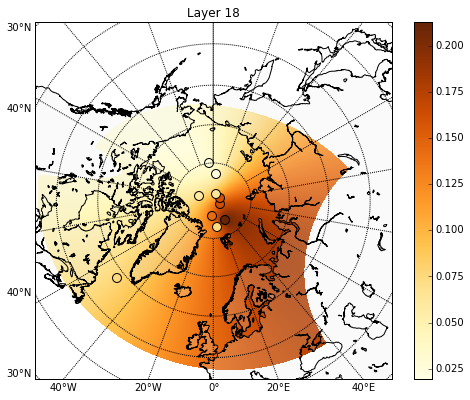

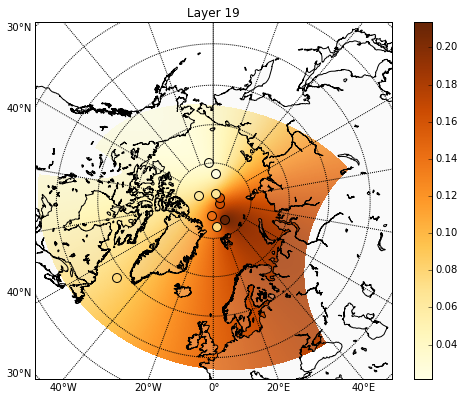

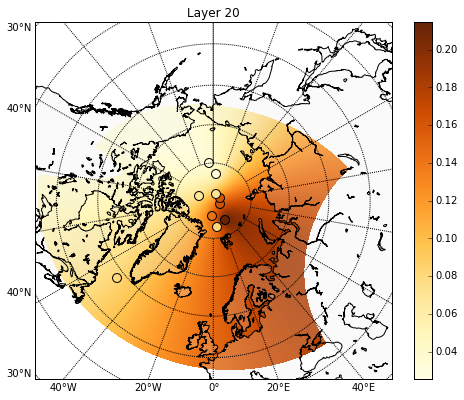

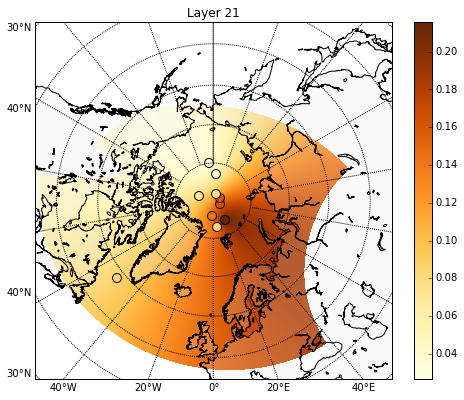

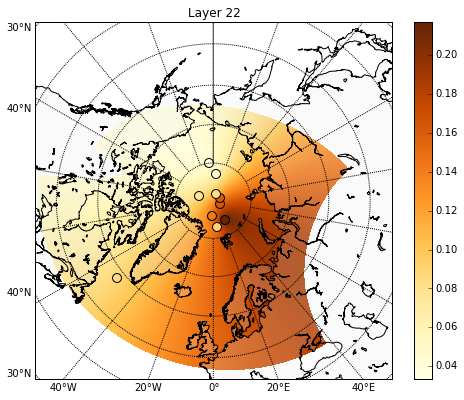

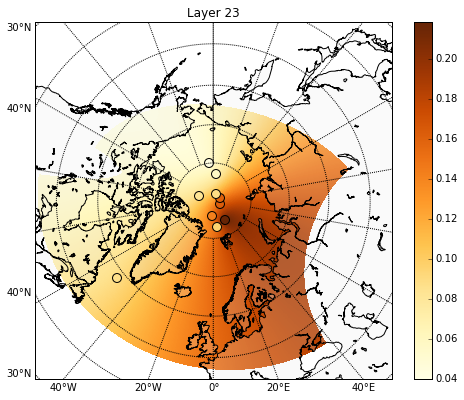

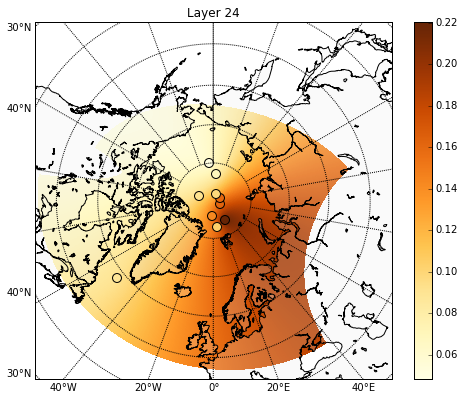

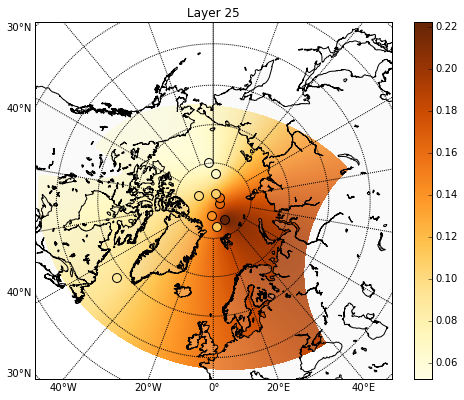

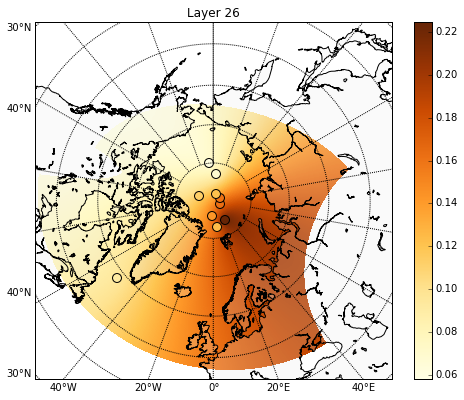

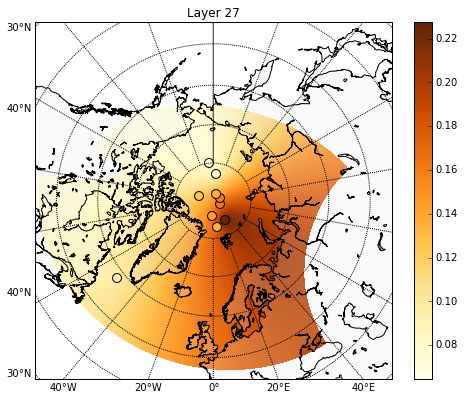

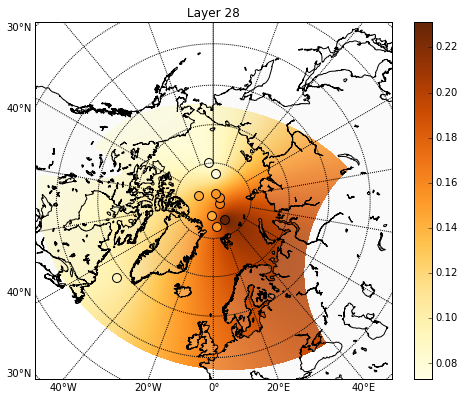

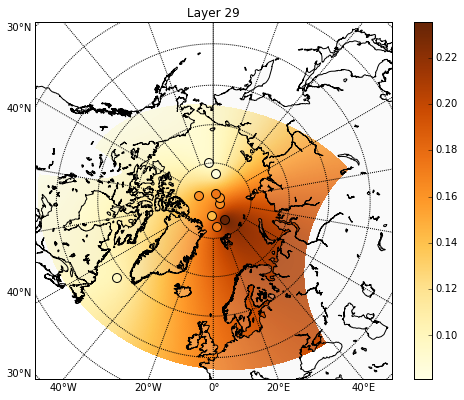

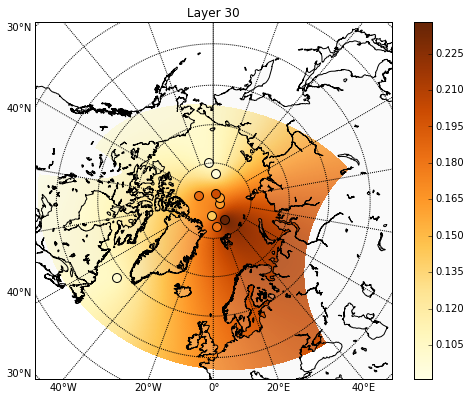

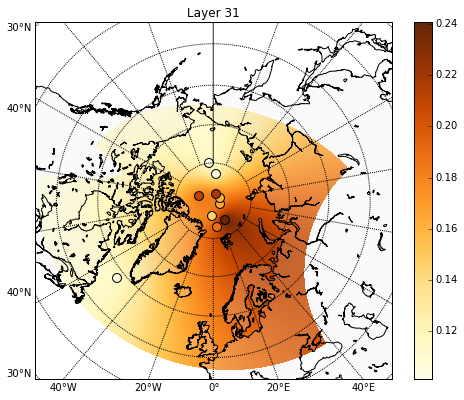

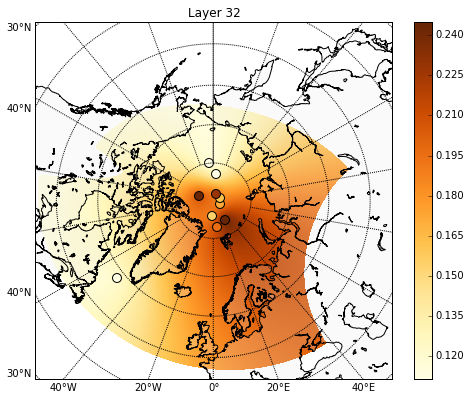

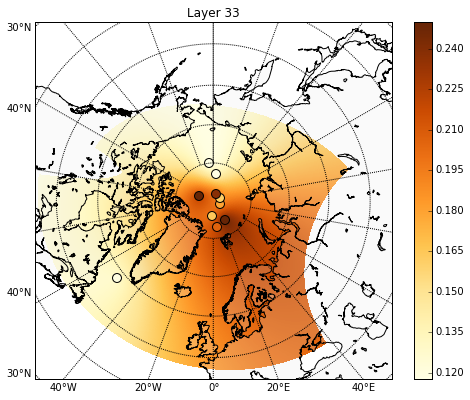

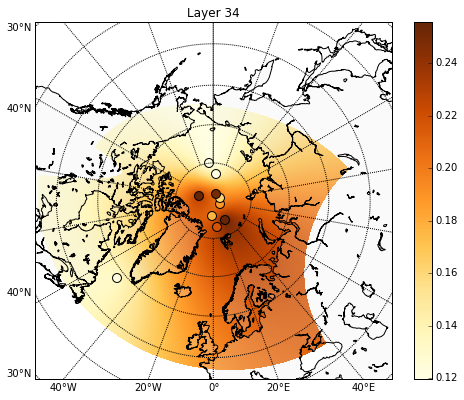

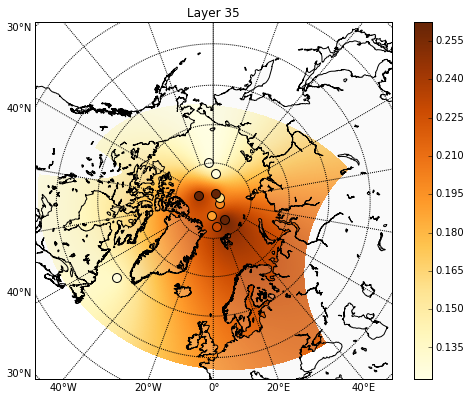

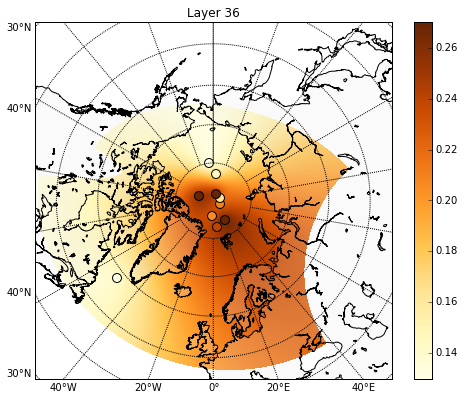

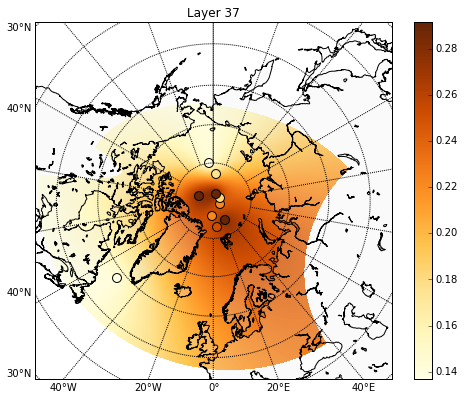

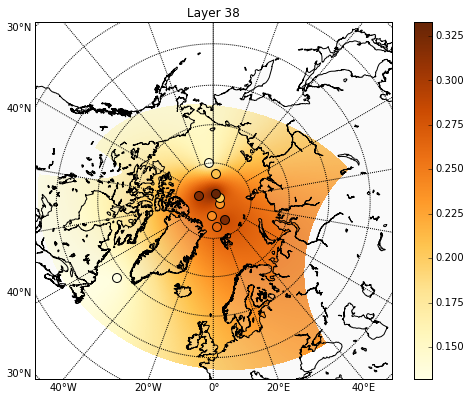

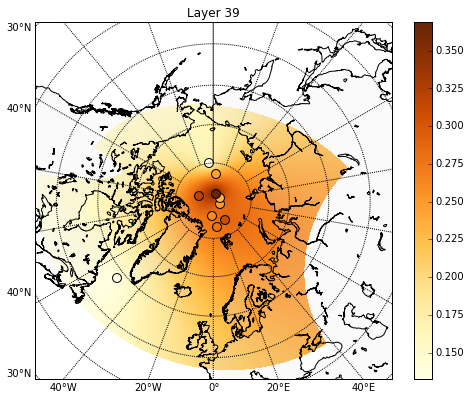

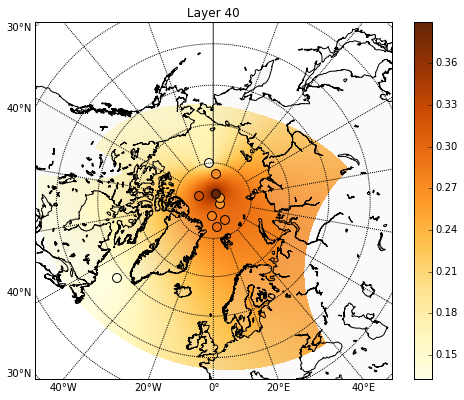

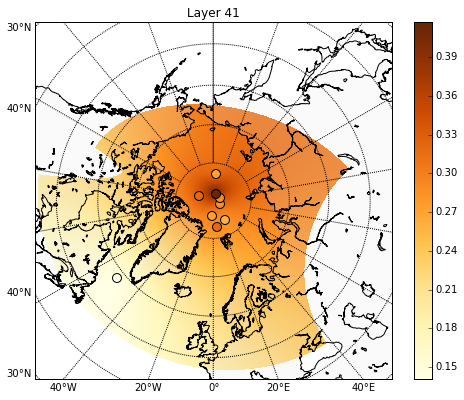

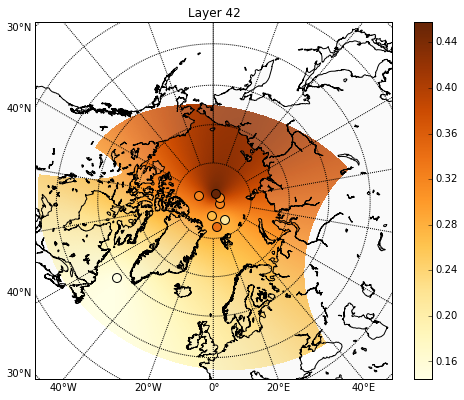

In [10]:
for i in range(43):
    write_nc(i)

#write the nc file

In [12]:
lat = nav_lat
lon = nav_lon
print lat.shape
xmax = lat.shape[1]
ymax = lat.shape[0]
depthtmax = NEMO_dep.shape[0]
print depthtmax
nemo = nc.Dataset('/ocean/xiaoxiny/research/data/data_ANHA_Pa_diss.nc', 'w')
nemo.description = 'Initial diss. Pa value' 

# dimensions
nemo.createDimension('x', xmax)
nemo.createDimension('y', ymax)
nemo.createDimension('deptht',depthtmax)
nemo.createDimension('time_counter', None)

# variables
# latitude and longitude
my_lat = nemo.createVariable('nav_lat','float32',('y','x'),zlib=True)
my_lat[:,:] = lat[:,:] 
x = nemo.createVariable('nav_lon','float32',('y','x'),zlib=True)
x[:,:]  = lon[:,:] 
# time
time_counter = nemo.createVariable('time_counter', 'float32', ('time_counter'),zlib=True)
time_counter.units = 'non-dim'
time_counter[0] = 1
# depth
depth = nemo.createVariable('deptht', 'float32', ('deptht'),zlib=True)
depth.units = 'meter'
depth[:] = ANHAdep[:]

Pa = nemo.createVariable('Pa_diss', 'float32', ('time_counter','deptht','y','x'), zlib=True)
Pa._units = 'arbitrary'
Pa[:,:,:,:]=Pa_ini[:,:,:,:]
nemo.close()

(800, 544)
50


In [12]:
#test .nc file

In [13]:
import glob,csv
nc_filename=glob.glob('/ocean/xiaoxiny/research/data/data_ANHA_Pa_diss.nc')
print("found *.nc file: \n{}".format(nc_filename))

found *.nc file: 
['/ocean/xiaoxiny/research/data/data_ANHA_Pa_diss.nc']


In [14]:
ptrc=nc.Dataset(nc_filename[0])
print ptrc.variables
lat=ptrc.variables['nav_lat'][:]
dept=ptrc.variables['deptht'][:]
Pa_diss=ptrc.variables['Pa_diss'][:]

OrderedDict([(u'nav_lat', <netCDF4.Variable object at 0x7f5fca8aeb00>), (u'nav_lon', <netCDF4.Variable object at 0x7f5fca8ae938>), (u'time_counter', <netCDF4.Variable object at 0x7f5fca8aecc8>), (u'deptht', <netCDF4.Variable object at 0x7f5fca8ae8a0>), (u'Pa_diss', <netCDF4.Variable object at 0x7f5fca8ae478>)])


In [19]:
#test input
Pa_diss[0,0,0,0:10]#-Pa_ini[0,0,0,0:10]

array([ 0.01664529,  0.01689756,  0.01715053,  0.01740419,  0.01765855,
        0.0179136 ,  0.01816933,  0.01842574,  0.01868284,  0.0189406 ], dtype=float32)

In [17]:
dept-ANHAdep

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [18]:
lat

array([[-20.07611084, -20.07611084, -20.07611084, ..., -20.07611084,
        -20.07611084, -20.07611084],
       [-19.8411274 , -19.8411274 , -19.8411274 , ..., -19.8411274 ,
        -19.8411274 , -19.8411274 ],
       [-19.605793  , -19.605793  , -19.605793  , ..., -19.605793  ,
        -19.605793  , -19.605793  ],
       ..., 
       [ 56.78784561,  56.80397415,  56.82052612, ...,  54.60116577,
         54.53417206,  54.46720886],
       [ 56.71054459,  56.72655106,  56.74296951, ...,  54.52142715,
         54.45484543,  54.38829041],
       [ 56.63286972,  56.64875031,  56.66504288, ...,  54.44150543,
         54.37533569,  54.30919266]], dtype=float32)